In [1]:
import pandas as pd
import altair as alt
from plotnine import *
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
maf = pd.read_csv('final_maf.maf',sep='\t')

In [3]:
maf['ANNOTATION'].unique()

array(['LIKELY_ONCOGENIC', 'ONCOGENIC', 'VUS', 'BENIGN'], dtype=object)

In [4]:
maf = maf[maf['ANNOTATION'].isin(['LIKELY_ONCOGENIC','ONCOGENIC'])]
maf['mut_id'] = maf['Hugo_Symbol'] + ':' + maf['HGVSc'] + ':' + maf['HGVSp_Short']
maf = maf[['mut_id','sample','Hugo_Symbol','Chromosome','Start_Position','End_Position','Variant_Classification','Variant_Type',
     'Reference_Allele','Tumor_Seq_Allele2','Consequence','ANNOTATION','t_vaf']]
maf.rename(columns={'Hugo_Symbol':'Gene','Tumor_Seq_Allele2':'Alt_Allele'},inplace=True)
maf['Composite_Mutation'] = 'False'

In [5]:
#adding Tissue Type information

tissue_type_info = pd.read_csv('oncotree_json_final_level2_bll_v2.txt',sep='\t',header=None)
tissue_type_info.columns = ['Sample','Cancer_Type_Short','Tissue Type','Specific Cancer']

In [6]:
maf['Tumor_Tissue_Type'] = 'NA'
maf['Cancer_Type'] = 'NA'
maf['Specific_Cancer'] = 'NA'
maf['short_sample'] = maf['sample'].apply(lambda x: x.split('.')[0].split('-')[0])
maf.reset_index(inplace=True)
maf.drop('index',axis=1,inplace=True)

In [7]:
for i in range(0,len(maf)):
    if(maf['short_sample'][i] in list(tissue_type_info['Sample'])):
        tissue_type = tissue_type_info[tissue_type_info.Sample == maf['short_sample'][i]].reset_index()['Tissue Type'][0]
        specific_cancer = tissue_type_info[tissue_type_info.Sample == maf['short_sample'][i]].reset_index()['Specific Cancer'][0]
        maf['Cancer_Type'][i] = tissue_type
        maf['Specific_Cancer'][i] = specific_cancer
        if(tissue_type in ['Lymphoid (LYMPH)','Myeloid (MYELOID)']):
            maf['Tumor_Tissue_Type'][i] = 'Liquid'
        else:
            maf['Tumor_Tissue_Type'][i] = 'Solid'


In [8]:
#maf.to_csv('maf_w_tissue.maf',sep='\t',header=True,index=None)

In [9]:
maf['Tumor_Tissue_Type'].value_counts()

Solid     606
Liquid    601
NA          5
Name: Tumor_Tissue_Type, dtype: int64

In [10]:
samples = maf['sample'].unique()
genes = maf['Gene'].unique()

In [11]:
#update composite mutation column of MAF accordingly

composite_mutation_dict = {} 

for sample in samples:
    composite_mutation_dict[sample] = {}
    for gene in genes:
        mut_maf = maf[(maf['sample'] == sample) & (maf['Gene'] == gene)]
        mut_maf.reset_index(inplace=True)
        length = len(mut_maf)
        
        if(length>1):
            composite_mutation_dict[sample][gene] = 1
            for i in range(0,len(mut_maf)):
                maf.loc[(maf['mut_id'] == mut_maf['mut_id'][i]) & (maf['sample']==sample),'Composite_Mutation']='True'
        else:
            composite_mutation_dict[sample][gene] = 0
        

## Copy Number Integration

In [12]:
pancan_data = pd.read_csv('pancan.all_data_by_genes.txt',sep='\t')
copath_mapping = pd.read_csv('all_copath_bathc_convert_merged.txt',sep='\t')
copath_mapping = pd.Series(copath_mapping.CPM_UID.values,index=copath_mapping.CoPATH).to_dict()
pancan_data.rename(columns = copath_mapping,inplace=True)

In [13]:
pancan_data['Gene Symbol'] = pancan_data['Gene Symbol'].apply(lambda x:x.split('|')[0])

curated_samples = list(pancan_data.columns)
#curated_samples = [i for i in curated_samples if 'CPM' in i]

In [14]:
#pancan_data has a few columns with copath IDs. This code converts them to CPM ids. 

copath_mapping = {str(k).split(';')[0]:v for k,v in copath_mapping.items()}
cpms = [i for i in curated_samples if i.startswith('CPM')]
copaths = [i for i in curated_samples if i.startswith('M')]
new_copaths = [copath_mapping[x] for x in copaths if x in list(copath_mapping.keys())]
curated_samples = cpms #+ new_copaths

In [15]:
pancan_data.rename(columns=lambda x:copath_mapping[x] if x in list(copath_mapping.keys()) else x,inplace=True)

In [16]:
maf['Copy_Number_Status'] = 'Unknown'
maf['CN_Value'] = 'NA'

for i in range(0,len(maf)):
    sample = maf['short_sample'][i]
    gene = maf['Gene'][i]
    
    if(sample in curated_samples):
        sample_specific_len = len(pancan_data[pancan_data['Gene Symbol'] == gene][sample])
    else:
        continue
    if(sample_specific_len < 1):
        continue
    else:
        cn_value =  pancan_data[pancan_data['Gene Symbol'] == gene][sample].reset_index().iloc[:,1][0]
        maf['CN_Value'][i] = cn_value
        if(cn_value > 0.2):
            maf['Copy_Number_Status'][i] = 'Gain'
        if(cn_value < -0.2 ):
            maf['Copy_Number_Status'][i] = 'Deletion'
        if((cn_value >= -0.2) & (cn_value <= 0.2)):
            maf['Copy_Number_Status'][i] = 'Neutral'

In [17]:
maf['Copy_Number_Status'].value_counts()

Neutral     595
Unknown     457
Deletion     86
Gain         74
Name: Copy_Number_Status, dtype: int64

In [18]:
# add LOH information to curated_composite_maf

loh_df = pd.read_csv('loh_df.txt',sep='\t')

In [19]:
for i in range(0,len(maf)):
    temp_df = loh_df[loh_df['short_name'] == maf['short_sample'][i]]
    if(len(temp_df)>0):
        temp_df.reset_index(inplace=True)
        genes = temp_df['Genes'][0].split(',')
        genes = [item.replace(' ','') for item in genes]
    
        if(maf['Gene'][i] in genes):
            maf['Copy_Number_Status'][i] = 'LOH'

In [20]:
maf['Copy_Number_Status'].value_counts()

Neutral     565
Unknown     453
Deletion     86
Gain         74
LOH          34
Name: Copy_Number_Status, dtype: int64

## Start looking at composite mutations

In [21]:
composite_maf = maf[maf['Composite_Mutation']=='True']
composite_maf['short_sample'] = composite_maf['sample'].apply(lambda x: x.split('.')[0].split('-')[0])

In [22]:
curated_composite_maf = composite_maf[composite_maf['short_sample'].isin(curated_samples)]

curated_composite_maf.reset_index(inplace=True)
curated_composite_maf.drop('index',axis=1,inplace=True)

In [23]:
curated_composite_maf['Copy_Number_Status'].value_counts()

Neutral     175
Gain         22
Deletion     14
Unknown       6
LOH           4
Name: Copy_Number_Status, dtype: int64

## Visualizations

#### TP53 Mutations Plot

In [24]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import matplotlib.font_manager as fm

from mizani.formatters import percent_format

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
title_fpath = 'fonts/PTSans-Bold.ttf'
body_fpath = 'fonts/PTSans-Regular.ttf'

title_text = fm.FontProperties(fname=title_fpath)
body_text =  fm.FontProperties(fname=body_fpath)

In [26]:
maf['Mut_Subgroup'] = 'Undefined'
for i in range(0,len(maf)):
    if(maf['Copy_Number_Status'][i]=='Deletion'):
        maf['Mut_Subgroup'][i] = 'Mut + Del'
    elif(maf['Copy_Number_Status'][i]=='LOH'):
        maf['Mut_Subgroup'][i] = 'LOH'
    else:
        if(maf['Composite_Mutation'][i] == 'True'):
            maf['Mut_Subgroup'][i] = '>1mut'
        else:
            maf['Mut_Subgroup'][i] = '1mut'
    

In [27]:
def get_date(s):
    start = re.search('_',s).span()[0] + 1
    return s[start:]

In [28]:
maf['Date'] = maf['sample'].apply(lambda x:get_date(x))

In [29]:
#keeping only first sample of every patients (if they have multiple samples)

final_count = 0
for sample in maf.short_sample.unique():
    df = maf[maf.short_sample == sample]
    earliest_date = sorted(list(df.Date.unique()))[0]
    count = len(df[(df['short_sample'] == sample) & (df['Date'] != earliest_date)])
    maf = maf.drop(df[(df['short_sample'] == sample) & (df['Date'] != earliest_date)].index)
    final_count = final_count + count

In [30]:
tp53_maf = maf[maf.Gene == 'TP53']

In [31]:
#tp53_maf.to_csv('tp53_maf.maf',sep='\t',index=False)

In [32]:
len(maf[maf.Specific_Cancer == 'Diffuse Glioma (DIFG)'][maf.Gene == 'TP53'])

25

In [33]:
pd.DataFrame(maf.Specific_Cancer.value_counts()).head(20)

Specific_Cancer
B-Lymphoblastic Leukemia/Lymphoma (BLL)                         238
Diffuse Glioma (DIFG)                                           140
Acute Myeloid Leukemia (AML)                                     79
Non-Hodgkin Lymphoma (NHL)                                       57
T-Lymphoblastic Leukemia/Lymphoma (TLL)                          42
Embryonal Tumor (EMBT)                                           39
Rhabdomyosarcoma (RMS)                                           35
Osteosarcoma (OS)                                                32
Encapsulated Glioma (ENCG)                                       28
Neuroblastoma (NBL)                                              27
Wilms Tumor (WT)                                                 25
Nerve Sheath Tumor (NST)                                         21
NON_NEOPLASTIC                                                   19
Histiocytic and Dendritic Cell Neoplasms (HDCN)                  15
Myelodysplastic/Myeloproliferative Neoplasms (M...               14
Desmoid/Aggressive Fibromatosis (DES)                            12
Hepatoblastoma (LIHB)                                            12
Miscellaneous Neuroepithelial Tumor (MNET)                       10
Sex Cord Stromal Tumor (SCST)                                     8
Acute Leukemias of Ambiguous Lineage (ALAL)                       8

In [34]:
maf[maf['Gene']=='TP53']['Mut_Subgroup'].value_counts()

1mut         43
Mut + Del    25
>1mut        21
LOH           3
Name: Mut_Subgroup, dtype: int64

In [35]:
maf.Cancer_Type.unique()

array(['Lymphoid (LYMPH)', 'CNS/Brain (BRAIN)', 'Myeloid (MYELOID)',
       'Adrenal Gland (ADRENAL_GLAND)', 'NON_NEOPLASTIC',
       'Soft Tissue (SOFT_TISSUE)', 'Kidney (KIDNEY)',
       'Pancreas (PANCREAS)', 'Ovary/Fallopian Tube (OVARY)',
       'Thyroid (THYROID)', 'Bone (BONE)',
       'Peripheral Nervous System (PNS)', 'LIVER', 'Liver (LIVER)',
       'Lung (LUNG)', 'Head and Neck (HEAD_NECK)', 'Eye (EYE)',
       'Other (OTHER)', 'BRAIN', 'BONE', 'SOFT_TISSUE', 'NA', 'OTHER',
       'ADRENAL_GLAND', 'Biliary Tract (BILIARY_TRACT)',
       'Testis (TESTIS)', 'Bowel (BOWEL)'], dtype=object)

In [36]:
viz = pd.DataFrame(maf[maf.Specific_Cancer == 'B-Lymphoblastic Leukemia/Lymphoma (BLL)'][maf.Gene == 'TP53']['Mut_Subgroup'].value_counts())
total = viz['Mut_Subgroup'].sum()
viz['Percentage of TP53 Subgroup'] = viz['Mut_Subgroup'].apply(lambda x:(x/total)*100)
viz.reset_index(inplace=True)

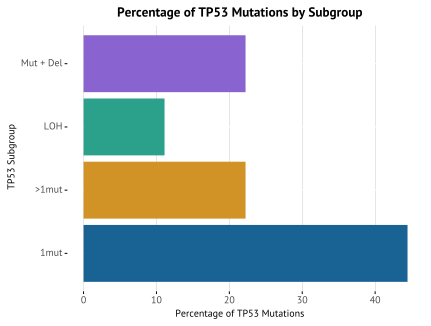

<ggplot: (8742316663278)>

In [37]:
cbbPalette = ("#186294", "#d19226", "#2ba18b","#8963cf")
cbbPalette2 = ('#d9c404', '#2384ad', "#53387d")

ggplot(viz) + aes(x='index',y='Percentage of TP53 Subgroup',fill='index') + geom_col() +coord_flip() + \
  scale_fill_manual(values=cbbPalette) + ggtitle('Percentage of TP53 Mutations by Subgroup') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_x = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none') + \
labs(x='TP53 Subgroup',y='Percentage of TP53 Mutations')

In [38]:
tp53_mutated_samples = list(maf[maf['Gene']=='TP53']['short_sample'].unique())
tp53_subset = list(set(tp53_mutated_samples) & set(curated_samples))

In [39]:
#here starts code to create setup for # of unique chromosomes with aberration per patient by group

def split_on_letter(s):
    match = re.compile("[^\W\d]").search(s)
    return [s[:match.start()], s[match.start():]]

pancan_data['Chromosome'] = pancan_data['Cytoband'].apply(lambda x:split_on_letter(x)[0])

In [40]:
pancan_data = pancan_data.loc[:,~pancan_data.columns.duplicated()]

In [41]:
chrom_aberration_count = {}

for sample in tp53_subset:
    gains = list(pancan_data[pancan_data['Chromosome'] != '17'][pancan_data[sample] > 0.2]['Chromosome'].unique())
    losses = list(pancan_data[pancan_data['Chromosome'] != '17'][pancan_data[sample] < -0.2]['Chromosome'].unique())
    lohs = list(loh_df[loh_df['short_name'] == sample][loh_df['Chromosome'] != '17']['Chromosome'].unique())
    
    chroms = list(set(gains+losses+lohs))
    chrom_aberration_count[sample] = len(chroms)   

In [42]:
chrom_aberration_count = {k:[v] for k,v in chrom_aberration_count.items()}
aber_count = pd.DataFrame.from_dict(chrom_aberration_count).transpose()
aber_count = aber_count.reset_index().rename(columns={'index':'Sample',0:'Count'})

In [43]:
aber_count['Mut_Subgroup'] = 'NA'
for i in range(0,len(aber_count)):
    sample = aber_count['Sample'][i]
    subgroup = maf[maf.short_sample == sample].reset_index()['Mut_Subgroup'][0]
    aber_count['Mut_Subgroup'][i] = subgroup

In [44]:
aber_count.Mut_Subgroup.value_counts()

1mut         32
Mut + Del    16
>1mut         5
LOH           1
Name: Mut_Subgroup, dtype: int64

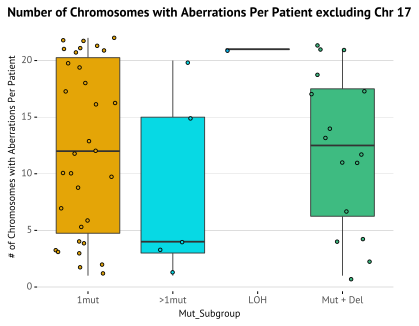

<ggplot: (8742314380361)>

In [56]:
cbbPalette3 = ("#e4a507","#07d9e4","#07b0e4","#3ebb81")

ggplot(aber_count) + aes(x='Mut_Subgroup',y='Count',fill='Mut_Subgroup') + geom_boxplot() + \
labs(title='Number of Chromosomes with Aberrations Per Patient excluding Chr 17',y='# of Chromosomes with Aberrations Per Patient') + \
geom_jitter() + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_y = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none') + scale_fill_manual(values=cbbPalette3)


In [44]:
driver_mutation_count = {}
for sample in tp53_mutated_samples:
    df = maf[maf.short_sample == sample]
    driver_mutation_count[sample] = len(df[df.Gene != 'TP53'])

In [45]:
driver_mutation_count = {k:[v] for k,v in driver_mutation_count.items()}
driver_count = pd.DataFrame.from_dict(driver_mutation_count).transpose()
driver_count = driver_count.reset_index().rename(columns={'index':'Sample',0:'Count'})

In [46]:
driver_count['Mut_Subgroup'] = 'NA'
for i in range(0,len(driver_count)):
    sample = driver_count['Sample'][i]
    subgroup = maf[maf.short_sample == sample][maf.Gene == 'TP53'].reset_index()['Mut_Subgroup'][0]
    driver_count['Mut_Subgroup'][i] = subgroup

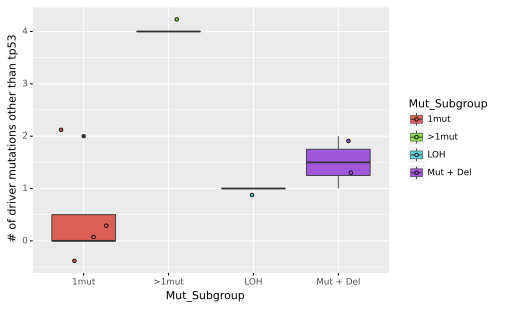

<ggplot: (8787522943076)>

In [47]:
ggplot(driver_count) + aes(x='Mut_Subgroup',y='Count',fill='Mut_Subgroup') + geom_boxplot() + labs(y='# of driver mutations other than tp53') +geom_jitter()

#### Tissue Source Investigation

In [48]:
def get_tissue_source(s):
    start = 1 + int(re.search('-',s).span()[0])
    end = int(re.search('_',s).span()[0])
    source = s[start:end]
    if(source[0:2] == 'B-'):
        return 'B-D'
    elif(source[0:2]=='P-'):
        return 'P-D'
    elif(source[0:2] == 'BM'):
        return 'BM-D'
    elif(source[0:2] == 'F-'):
        return 'F-D'
    else:
        return source

In [49]:
maf['Tissue_Source'] = maf['sample'].apply(lambda x:get_tissue_source(x))

In [50]:
mutations_per_source = {}
for source in list(maf.Tissue_Source.unique()):
    df = maf[maf.Tissue_Source == source]
    num_samples = df['sample'].nunique()
    mutations_per_source[source] = len(df)/num_samples

In [51]:
mutations_per_source

{'BM-D': 2.050955414012739,
 'F-D': 1.8518518518518519,
 'P-D': 1.7179487179487178,
 'B-D': 2.076923076923077,
 'SK-D': 1.0,
 'CSF-D': 1.0}

#### Genomic Instability Analysis

In [56]:
seg_file = pd.read_csv('oncoscan_chas_pancan.seg',sep='\t')
seg_file = seg_file[~seg_file['Chromosome'].isin([23,24])].reset_index()
seg_file.drop('index',axis=1,inplace=True)

In [57]:
for i in range(0,len(seg_file)):
    sample = seg_file['Sample'][i]
    if(sample in list(copath_mapping.keys())):
        seg_file['Sample'][i] = copath_mapping[sample]

In [58]:
seg_samples = list(seg_file['Sample'].unique())
seg_samples = [i for i in seg_samples if 'CPM' in i]
seg_file = seg_file[seg_file['Sample'].isin(seg_samples)]
seg_file.reset_index(inplace=True)
seg_file.drop('index',axis=1,inplace=True)

In [59]:
seg_file['CN_Status'] = 'NA'

In [60]:
for i in range(0,len(seg_file)):
    cn_value = seg_file['Seg.CN'][i]
    if(cn_value > 0.2):
        seg_file['CN_Status'][i] = 'Gain'
    if(cn_value < -0.2 ):
        seg_file['CN_Status'][i] = 'Deletion'
    if((cn_value >= -0.2) & (cn_value <= 0.2)):
        seg_file['CN_Status'][i] = 'Neutral'

In [61]:
genomic_instability_scores= {}

In [62]:
for sample in list(seg_file['Sample'].unique()):
    df = seg_file[seg_file['Sample']==sample]
    total_length = 0
    altered_length = 0
    for chrom in list(df['Chromosome'].unique()):
        sub_df = df[df['Chromosome'] == chrom]
        sub_df.drop_duplicates(subset=['Start Position','End Position'],inplace=True)
        sub_df.sort_values(by='End Position',ascending=True)
        total_length = total_length + sub_df.reset_index()['End Position'][len(sub_df)-1]
        
        sub_alt_df = sub_df[(sub_df['CN_Status'] == 'Gain') | (sub_df['CN_Status'] == 'Deletion')]
        if(len(sub_alt_df) > 0):
            for i in range(0,len(sub_alt_df)):
                start = sub_alt_df.reset_index()['Start Position'][i]
                end = sub_alt_df.reset_index()['End Position'][i]
                altered_length = altered_length + (end - start)
    score = altered_length/total_length
    genomic_instability_scores[sample] = score

In [63]:
genomic_instability_scores

{'CPM00000147': 0.07613116483791989,
 'CPM00000366': 0.020373238061922205,
 'CPM00003576': 0.1671411175080745,
 'CPM00005156': 0.2574974484345475,
 'CPM00005185': 0.07756301709038985,
 'CPM00005184': 0.017776528389613338,
 'CPM00005187': 0.09350811991972244,
 'CPM00005192': 0.010444791196285065,
 'CPM00004386': 0.08879542962372501,
 'CPM00005202': 6.106281411425525e-05,
 'CPM00005209': 0.05521526730462079,
 'CPM00003437': 0.00012885515825310738,
 'CPM00003690': 0.7071841085061257,
 'CPM00005241': 0.011806882678272535,
 'CPM00005248': 0.1446243432954214,
 'CPM00005254': 0.0034514717508890317,
 'CPM00005237': 0.9177066762289396,
 'CPM00005297': 0.06713990391570922,
 'CPM00005293': 0.2873871371161937,
 'CPM00005160': 0.0128382237649718,
 'CPM00005308': 0.029317739024553566,
 'CPM00005328': 0.36737135544128624,
 'CPM00005339': 0.011797425654595508,
 'CPM00005348': 2.7926785987157805e-05,
 'CPM00005346': 0.12116450083943946,
 'CPM00005358': 0.02000019620738252,
 'CPM00005359': 0.00921162248

In [64]:
trouble_pairs = dict((k, v) for k, v in genomic_instability_scores.items() if v > 1)
trouble_keys = list(trouble_pairs.keys())

In [65]:
#alternative

multi_hit_tp53_samples = list(maf[maf['Tumor_Tissue_Type']=='Liquid']['short_sample'].unique())
single_hit_tp53_samples = list(maf[maf['Tumor_Tissue_Type']=='Solid']['short_sample'].unique())

In [66]:
multi_hit_tp53_samples = list(maf[maf['Gene']=='TP53'][maf['Mut_Subgroup'].isin(['Mut + Del','>1mut','LOH'])]['short_sample'].unique())
single_hit_tp53_samples = list(maf[maf['Gene']=='TP53'][maf['Mut_Subgroup'] == '1mut']['short_sample'].unique())

In [67]:
list(set(single_hit_tp53_samples) & set(trouble_keys))

['CPM00005626']

In [68]:
trouble = list(set(multi_hit_tp53_samples) & set(trouble_keys))
#multi_hit_tp53_samples.remove(trouble[0])
trouble = list(set(single_hit_tp53_samples) & set(trouble_keys))
single_hit_tp53_samples.remove(trouble[0])

In [69]:
multi_hit_tp53_data = dict((k, v) for k, v in genomic_instability_scores.items() if k in multi_hit_tp53_samples)
multi_hit_tp53_data = pd.DataFrame(multi_hit_tp53_data,index=['Score']).transpose()
single_hit_tp53_data = dict((k, v) for k, v in genomic_instability_scores.items() if k in single_hit_tp53_samples)
single_hit_tp53_data = pd.DataFrame(single_hit_tp53_data,index=['Score']).transpose()

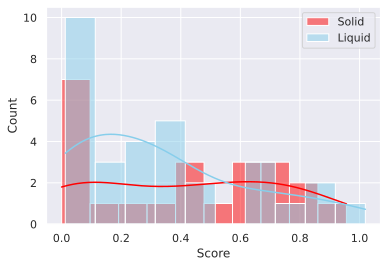

In [70]:
sns.set(style="darkgrid")

sns.histplot(single_hit_tp53_data['Score'], color="red", kde=True,label='Solid',bins=10)
sns.histplot(multi_hit_tp53_data['Score'], color="skyblue", kde=True,label='Liquid',bins=10)

plt.legend() 
plt.show()

In [71]:
from scipy import stats

In [72]:
stats.ttest_ind(single_hit_tp53_data['Score'],multi_hit_tp53_data['Score'])

Ttest_indResult(statistic=0.9802306555888435, pvalue=0.3315109777031813)

In [73]:
def cohens_d(group1,group2):
    n1 = len(group1)
    n2 = len(group2)
    N = n1 + n2
    var1 = group1.var()
    var2 = group2.var()
    pooled_sd = (((n1-1)*var1 + (n2-1)*var2)/(N-2))**0.5
    d = (group1.mean()-group2.mean())/pooled_sd
    return d

In [74]:
cohens_d(single_hit_tp53_data['Score'],multi_hit_tp53_data['Score'])

0.26976176560612325

### Composite Mutations by Patient/Gene

In [57]:
cgc_gene_info = pd.read_csv('cgc.txt')

In [58]:
cgc_gene_info['Role in Cancer'].unique()

array(['oncogene', 'TSG', 'oncogene, fusion', 'fusion', 'oncogene, TSG',
       'oncogene, TSG, fusion', nan, 'TSG, fusion'], dtype=object)

In [59]:
def get_gene_function(gene):
    df = cgc_gene_info[cgc_gene_info['Gene Symbol'] == gene]
    if(len(df)>0):
        role = cgc_gene_info[cgc_gene_info['Gene Symbol'] == gene].reset_index()['Role in Cancer'][0]
        return role
    else:
        return 'NA'

In [60]:
maf['Cancer_Role'] = maf['Gene'].apply(lambda x:get_gene_function(x))

In [61]:
maf['Cancer_Role'].unique()

array(['oncogene, fusion', 'oncogene', 'TSG, fusion', 'TSG',
       'oncogene, TSG', 'oncogene, TSG, fusion', 'NA'], dtype=object)

In [62]:
oncogene_tsg_maf = maf[maf.Cancer_Role.isin(['oncogene','TSG'])]

In [63]:
oncogene_maf = maf[maf.Cancer_Role == 'oncogene'][maf.Composite_Mutation == 'True']

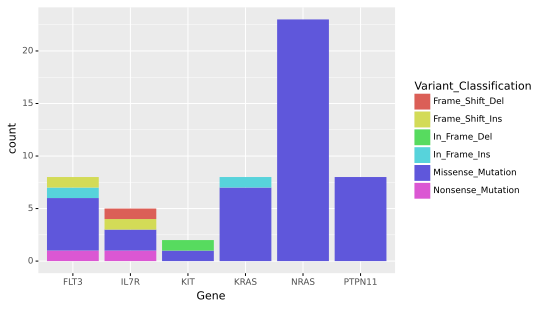

<ggplot: (8742316099856)>

In [64]:
cPalette = ("#186294", "#d19226", "#2ba18b","#8963cf","#d05025","#55d025","#ab25d0")

ggplot(oncogene_maf) + aes(x='Gene',fill='Variant_Classification') + geom_bar() 

In [65]:
ggplot(tsg_maf) + aes(x='Gene',fill='Variant_Classification') + geom_bar() 

NameError: name 'tsg_maf' is not defined

In [66]:
oncogene_maf.Variant_Classification.value_counts()

Missense_Mutation    46
In_Frame_Ins          2
Frame_Shift_Ins       2
Nonsense_Mutation     2
Frame_Shift_Del       1
In_Frame_Del          1
Name: Variant_Classification, dtype: int64

In [75]:
tsg_maf.Variant_Classification.value_counts()

Missense_Mutation    22
Frame_Shift_Ins       9
Nonsense_Mutation     8
Frame_Shift_Del       8
Splice_Site           5
In_Frame_Ins          2
Name: Variant_Classification, dtype: int64

In [72]:
tsg_maf = maf[maf.Cancer_Role == 'TSG'][maf.Composite_Mutation == 'True']

In [58]:
role_counts_onc = {}

for gene in list(oncogene_tsg_maf['Gene'].unique()):
    df= oncogene_tsg_maf[oncogene_tsg_maf['Gene']==gene][oncogene_tsg_maf['Composite_Mutation']=='True'][oncogene_tsg_maf['Cancer_Role']=='oncogene']
    num_samples = df['short_sample'].nunique()
    
    role_counts_onc[gene] = []
    role_counts_onc[gene].append(num_samples)


In [59]:
role_counts_onc = pd.DataFrame.from_dict(role_counts_onc).transpose()
role_counts_onc.rename(columns={0:'counts'},inplace=True)
role_counts_onc.reset_index(inplace=True)
role_counts_onc.rename(columns={'index':'Gene'},inplace=True)

In [60]:
viz = role_counts_onc[role_counts_onc['counts']>0]
viz = viz[viz.Gene != 'TPMT']

In [61]:
viz.counts.sum()

24

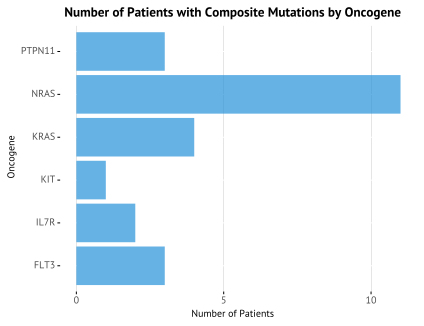

<ggplot: (8787522687452)>

In [62]:
ggplot(viz) + aes(x='Gene',y='counts') + geom_col(fill='#2591d9',alpha=0.7) + coord_flip() + \
ggtitle('Number of Patients with Composite Mutations by Oncogene') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_x = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none') + \
labs(x='Oncogene',y='Number of Patients') + \
scale_y_continuous(breaks = range(0, 85,5))

In [85]:
role_counts_tsg = {}

for gene in list(oncogene_tsg_maf['Gene'].unique()):
    df= oncogene_tsg_maf[oncogene_tsg_maf['Gene']==gene][oncogene_tsg_maf['Composite_Mutation']=='True'][oncogene_tsg_maf['Cancer_Role']=='TSG']
    num_samples = df['short_sample'].nunique()
    
    role_counts_tsg[gene] = []
    role_counts_tsg[gene].append(num_samples)

In [86]:
role_counts_tsg = pd.DataFrame.from_dict(role_counts_tsg).transpose()
role_counts_tsg.rename(columns={0:'counts'},inplace=True)
role_counts_tsg.reset_index(inplace=True)
role_counts_tsg.rename(columns={'index':'Gene'},inplace=True)

In [87]:
viz = role_counts_tsg[role_counts_tsg['counts']>0]
viz = viz[viz.Gene != 'TPMT']

In [90]:
viz['counts'].sum()

26

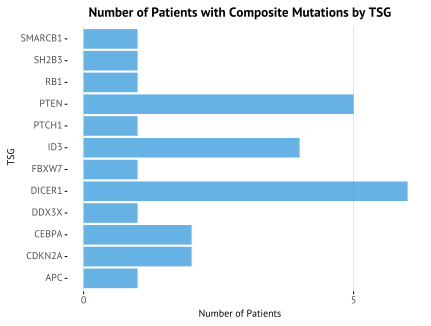

<ggplot: (8768932797681)>

In [88]:
ggplot(viz) + aes(x='Gene',y='counts') + geom_col(fill='#2591d9',alpha=0.7) + coord_flip() + \
ggtitle('Number of Patients with Composite Mutations by TSG') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_x = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none') + \
labs(x='TSG',y='Number of Patients') + \
scale_y_continuous(breaks = range(0, 85,5))

#### Composite Mutations vs Non-Composite Mutations by Gene

In [74]:
comp_genes = list(maf[maf.Composite_Mutation == 'True']['Gene'].unique())

In [78]:
comp_genes = comp_genes[:-1]

In [79]:
plot_maf = maf[maf['Gene'].isin(comp_genes)]

In [109]:
cbbPalette4 = ("#2591d9","#3ebb81")

p4 = ggplot(plot_maf) + aes(x='Gene',fill='Composite_Mutation') + geom_bar(position='stack') + coord_flip() + \
labs(y='Number of Mutations',title='Number of Composite/Non-Composite Mutations by Gene',color=" ") + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_x = element_line( size=.1, color="black" ),
      panel_grid_minor_x = element_line( size=.1, color="black" ),legend_title=element_blank(),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text)) + \
scale_fill_manual(values=cbbPalette4,labels = ("Mutation", "Composite Mutation"))

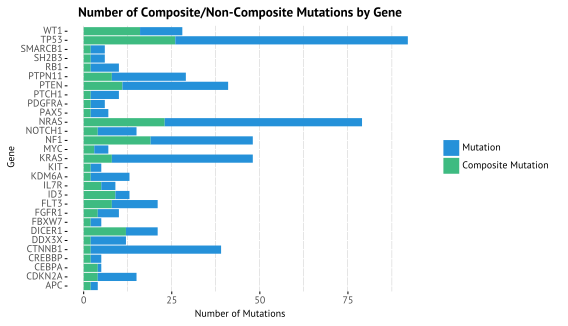

<ggplot: (8742314228661)>

In [110]:
p4

In [67]:
maf

mut_id                     sample    Gene  \
0                ALK:c.3599C>T:p.A1200V  CPM00000165-BM-D_20200406     ALK   
1                BRAF:c.1799T>A:p.V600E   CPM00000331-F-D_20190826    BRAF   
2                   NRAS:c.37G>C:p.G13R  CPM00000346-BM-D_20170801    NRAS   
3                NF1:c.5902C>T:p.R1968*  CPM00000366-BM-D_20191202     NF1   
4                CDKN2A:c.207G>C:p.E69D   CPM00000379-P-D_20200204  CDKN2A   
...                                 ...                        ...     ...   
1207            PIK3CA:c.323G>A:p.R108H   CPM00018670-F-D_20210401  PIK3CA   
1208              TPMT:c.719A>G:p.Y240C  CPM00018693-BM-D_20210401    TPMT   
1209              TPMT:c.460G>A:p.A154T  CPM00018693-BM-D_20210401    TPMT   
1210             ALK:c.3824G>A:p.R1275Q   CPM00018704-P-D_20210407     ALK   
1211  SUZ12:c.1150_1151del:p.L385Pfs*10   CPM00018706-F-D_20210407   SUZ12   

     Chromosome  Start_Position  End_Position Variant_Classification  \
0             2        29443618      29443618      Missense_Mutation   
1             7       140453136     140453136      Missense_Mutation   
2             1       115258745     115258745      Missense_Mutation   
3            17        29661945      29661945      Nonsense_Mutation   
4             9        21971151      21971151      Missense_Mutation   
...         ...             ...           ...                    ...   
1207          3       178916936     178916936      Missense_Mutation   
1208          6        18130918      18130918      Missense_Mutation   
1209          6        18139228      18139228      Missense_Mutation   
1210          2        29432664      29432664      Missense_Mutation   
1211         17        30315461      30315462        Frame_Shift_Del   

     Variant_Type Reference_Allele Alt_Allele  ... Composite_Mutation  \
0             SNP                G          A  ...              False   
1             SNP                A          T  ...              False   
2             SNP                C          G  ...              False   
3             SNP                C          T  ...              False   
4             SNP                C          G  ...              False   
...           ...              ...        ...  ...                ...   
1207          SNP                G          A  ...              False   
1208          SNP                T          C  ...               True   
1209          SNP                C          T  ...               True   
1210          SNP                C          T  ...              False   
1211          DEL               AG          -  ...              False   

     Tumor_Tissue_Type                      Cancer_Type  \
0               Liquid                 Lymphoid (LYMPH)   
1                Solid                CNS/Brain (BRAIN)   
2               Liquid                Myeloid (MYELOID)   
3               Liquid                Myeloid (MYELOID)   
4                Solid                CNS/Brain (BRAIN)   
...                ...                              ...   
1207             Solid                CNS/Brain (BRAIN)   
1208            Liquid                Myeloid (MYELOID)   
1209            Liquid                Myeloid (MYELOID)   
1210             Solid  Peripheral Nervous System (PNS)   
1211             Solid  Peripheral Nervous System (PNS)   

                                        Specific_Cancer short_sample  \
0               B-Lymphoblastic Leukemia/Lymphoma (BLL)  CPM00000165   
1                                 Diffuse Glioma (DIFG)  CPM00000331   
2                          Acute Myeloid Leukemia (AML)  CPM00000346   
3           Acute Leukemias of Ambiguous Lineage (ALAL)  CPM00000366   
4                                Embryonal Tumor (EMBT)  CPM00000379   
...                                                 ...          ...   
1207                              Diffuse Glioma (DIFG)  CPM00018670   
1208  Blastic Plasmacytoid Dendritic Cell Neoplasm (...  CPM00018693 

In [97]:
maf.Cancer_Type.value_counts()

Lymphoid (LYMPH)                   337
CNS/Brain (BRAIN)                  236
Myeloid (MYELOID)                  129
Soft Tissue (SOFT_TISSUE)           58
Peripheral Nervous System (PNS)     49
Bone (BONE)                         36
Kidney (KIDNEY)                     27
NON_NEOPLASTIC                      19
Liver (LIVER)                       14
Ovary/Fallopian Tube (OVARY)        14
Thyroid (THYROID)                    9
Lung (LUNG)                          8
Head and Neck (HEAD_NECK)            6
NA                                   5
OTHER                                5
SOFT_TISSUE                          5
Eye (EYE)                            3
Biliary Tract (BILIARY_TRACT)        3
LIVER                                2
BONE                                 2
Pancreas (PANCREAS)                  2
BRAIN                                1
Adrenal Gland (ADRENAL_GLAND)        1
Testis (TESTIS)                      1
ADRENAL_GLAND                        1
Other (OTHER)            

In [178]:
myeloid_maf = maf[maf.Tumor_Tissue_Type == 'Liquid']

In [179]:
composite_counts = {}

for gene in list(myeloid_maf['Gene'].unique()):
    df= myeloid_maf[myeloid_maf['Gene']==gene][myeloid_maf['Composite_Mutation']=='True']
    num_samples = df['short_sample'].nunique()
    
    composite_counts[gene] = []
    composite_counts[gene].append(num_samples)

In [180]:
composite_counts = pd.DataFrame.from_dict(composite_counts).transpose()
composite_counts.rename(columns={0:'counts'},inplace=True)
composite_counts.reset_index(inplace=True)
composite_counts.rename(columns={'index':'Gene'},inplace=True)

In [181]:
viz = composite_counts[composite_counts['counts']>1]
viz = viz[viz.Gene != 'TPMT']

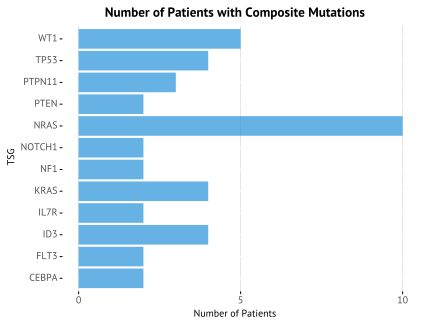

<ggplot: (8744694930731)>

In [182]:
ggplot(viz) + aes(x='Gene',y='counts') + geom_col(fill='#2591d9',alpha=0.7) + coord_flip() + \
ggtitle('Number of Patients with Composite Mutations') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_x = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none') + \
labs(x='TSG',y='Number of Patients') + \
scale_y_continuous(breaks = range(0, 85,5))

In [183]:
non_composite_counts = {}

for gene in list(myeloid_maf['Gene'].unique()):
    df= myeloid_maf[myeloid_maf['Gene']==gene][myeloid_maf['Composite_Mutation']=='False']
    num_samples = df['short_sample'].nunique()
    
    non_composite_counts[gene] = []
    non_composite_counts[gene].append(num_samples)

In [184]:
non_composite_counts = pd.DataFrame.from_dict(non_composite_counts).transpose()
non_composite_counts.rename(columns={0:'counts'},inplace=True)
non_composite_counts.reset_index(inplace=True)
non_composite_counts.rename(columns={'index':'Gene'},inplace=True)

In [185]:
viz = non_composite_counts[non_composite_counts['counts']>5]
viz = viz[viz.Gene != 'TPMT']

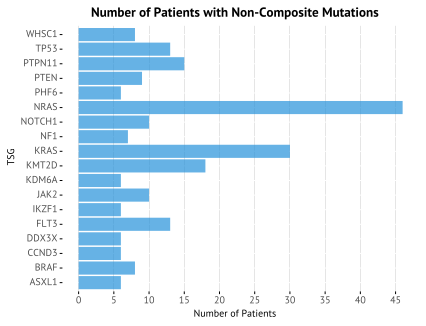

<ggplot: (8744694749350)>

In [186]:
ggplot(viz) + aes(x='Gene',y='counts') + geom_col(fill='#2591d9',alpha=0.7) + coord_flip() + \
ggtitle('Number of Patients with Non-Composite Mutations') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_x = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none') + \
labs(x='TSG',y='Number of Patients') + \
scale_y_continuous(breaks = range(0, 85,5))

In [187]:
a = composite_counts[composite_counts['counts']>0] 
b = non_composite_counts[non_composite_counts['counts']>0]

In [190]:
c=pd.merge(a,b,on='Gene',how='right')

In [197]:
c[c.counts_x.isna()].sort_values('counts_y',ascending = False)

Gene  counts_x  counts_y
3        KMT2D       NaN        18
15        JAK2       NaN        10
16        BRAF       NaN         8
43       WHSC1       NaN         8
36        PHF6       NaN         6
35       CCND3       NaN         6
13       IKZF1       NaN         6
32       ASXL1       NaN         6
41      ARID1A       NaN         5
14       GATA1       NaN         5
47        JAK1       NaN         5
21       SETD2       NaN         4
42       GNA13       NaN         4
44       RUNX1       NaN         3
40        IDH2       NaN         3
25      CDKN2A       NaN         3
55       GATA2       NaN         3
10      STAT5B       NaN         3
22       CRLF2       NaN         3
45         CBL       NaN         2
46       GATA3       NaN         2
60       PRPS1       NaN         2
37      PIK3R1       NaN         2
31        EZH2       NaN         2
29     SMARCA4       NaN         2
53        JAK3       NaN         2
57       SUZ12       NaN         1
58         APC       NaN         1
52        MSH6       NaN         1
61       NT5C2       NaN         1
62  CDKN2B-AS1       NaN         1
63         RB1       NaN         1
64       FGFR4       NaN         1
54        NPM1       NaN         1
0          ALK       NaN         1
51        USP7       NaN         1
50       ASXL2       NaN         1
48        TET2       NaN         1
39       STAT3       NaN         1
38        MTOR       NaN         1
34       CSF3R       NaN         1
27       ERBB4       NaN         1
24      PIK3CA       NaN         1
20      SETBP1       NaN         1
11        ABL1       NaN         1
65        ATRX       NaN         1

In [177]:
maf

mut_id                     sample    Gene  \
0                ALK:c.3599C>T:p.A1200V  CPM00000165-BM-D_20200406     ALK   
1                BRAF:c.1799T>A:p.V600E   CPM00000331-F-D_20190826    BRAF   
2                   NRAS:c.37G>C:p.G13R  CPM00000346-BM-D_20170801    NRAS   
3                NF1:c.5902C>T:p.R1968*  CPM00000366-BM-D_20191202     NF1   
4                CDKN2A:c.207G>C:p.E69D   CPM00000379-P-D_20200204  CDKN2A   
...                                 ...                        ...     ...   
1207            PIK3CA:c.323G>A:p.R108H   CPM00018670-F-D_20210401  PIK3CA   
1208              TPMT:c.719A>G:p.Y240C  CPM00018693-BM-D_20210401    TPMT   
1209              TPMT:c.460G>A:p.A154T  CPM00018693-BM-D_20210401    TPMT   
1210             ALK:c.3824G>A:p.R1275Q   CPM00018704-P-D_20210407     ALK   
1211  SUZ12:c.1150_1151del:p.L385Pfs*10   CPM00018706-F-D_20210407   SUZ12   

     Chromosome  Start_Position  End_Position Variant_Classification  \
0             2        29443618      29443618      Missense_Mutation   
1             7       140453136     140453136      Missense_Mutation   
2             1       115258745     115258745      Missense_Mutation   
3            17        29661945      29661945      Nonsense_Mutation   
4             9        21971151      21971151      Missense_Mutation   
...         ...             ...           ...                    ...   
1207          3       178916936     178916936      Missense_Mutation   
1208          6        18130918      18130918      Missense_Mutation   
1209          6        18139228      18139228      Missense_Mutation   
1210          2        29432664      29432664      Missense_Mutation   
1211         17        30315461      30315462        Frame_Shift_Del   

     Variant_Type Reference_Allele Alt_Allele  ... Composite_Mutation  \
0             SNP                G          A  ...              False   
1             SNP                A          T  ...              False   
2             SNP                C          G  ...              False   
3             SNP                C          T  ...              False   
4             SNP                C          G  ...              False   
...           ...              ...        ...  ...                ...   
1207          SNP                G          A  ...              False   
1208          SNP                T          C  ...               True   
1209          SNP                C          T  ...               True   
1210          SNP                C          T  ...              False   
1211          DEL               AG          -  ...              False   

     Tumor_Tissue_Type                      Cancer_Type short_sample  \
0               Liquid                 Lymphoid (LYMPH)  CPM00000165   
1                Solid                CNS/Brain (BRAIN)  CPM00000331   
2               Liquid                Myeloid (MYELOID)  CPM00000346   
3               Liquid                Myeloid (MYELOID)  CPM00000366   
4                Solid                CNS/Brain (BRAIN)  CPM00000379   
...                ...                              ...          ...   
1207             Solid                CNS/Brain (BRAIN)  CPM00018670   
1208            Liquid                Myeloid (MYELOID)  CPM00018693   
1209            Liquid                Myeloid (MYELOID)  CPM00018693   
1210             Solid  Peripheral Nervous System (PNS)  CPM00018704   
1211             Solid  Peripheral Nervous System (PNS)  CPM00018706   

     Copy_Number_Status CN_Value Mut_Subgroup      Date Tissue_Source  \
0               Neutral     0.05         1mut  20200406          BM-D   
1               Unknown       NA         1mut  20190826           F-D   
2               Neutral     0.05         1mut  20170801          BM-D   
3                   LOH      0.0          LOH  20191202          BM-D   
4               Unknown       NA         1mut  20200204           P-D   
...                 ...      ...          ...      

### Mutations/Composite Mutations by Liquid and Solid ###

In [239]:
gene_counts={}

for gene in list(maf['Gene'].unique()):
    df= maf[maf['Gene']==gene][maf['Composite_Mutation']=='False']
    num_samples = df['short_sample'].nunique()
    
    gene_counts[gene] = []
    gene_counts[gene].append(num_samples)
    
gene_counts = pd.DataFrame.from_dict(gene_counts).transpose()
gene_counts.rename(columns={0:'counts'},inplace=True)
gene_counts.reset_index(inplace=True)
gene_counts.rename(columns={'index':'Gene'},inplace=True)

In [240]:
composite_gene_counts={}

for gene in list(maf['Gene'].unique()):
    df= maf[maf['Gene']==gene][maf['Composite_Mutation']=='True']
    num_samples = df['short_sample'].nunique()
    
    composite_gene_counts[gene] = []
    composite_gene_counts[gene].append(num_samples)

In [241]:
composite_gene_counts = pd.DataFrame(composite_gene_counts).transpose()
composite_gene_counts.reset_index(inplace=True)
composite_gene_counts.rename(columns={'index':'Gene',0:'composite_count'},inplace=True)

In [242]:
merged_counts = pd.merge(gene_counts,composite_gene_counts,on='Gene')
merged_counts['ratio'] = merged_counts.composite_count/merged_counts.counts
merged_counts.sort_values(by='ratio',ascending=False,inplace=True)

In [243]:
merged_counts = merged_counts[merged_counts.Gene != 'TPMT']
merged_counts['n'] = merged_counts.counts + merged_counts.composite_count

In [244]:
gene_list = merged_counts.Gene.to_list()
gene_cat = pd.Categorical(merged_counts.Gene,categories = gene_list)

In [245]:
merged_counts['cat'] = gene_cat

In [246]:
viz = merged_counts[merged_counts['ratio']>0]

In [253]:
p1 = ggplot(viz) + aes(x='cat',y='ratio') + geom_col(fill='#46A0D8',alpha=0.85) + coord_flip() + \
labs(y='Ratio of Patients with Composite Mutations to Patients with Non-Composite Mutations',x='Gene',title='Ratio of Patients with Composite to Non-Composite Mutations by Gene') + \
theme(panel_background = element_rect(fill = 'white'), panel_grid_minor_x = element_line( size=.1, color="black" ),
      panel_grid_major_x = element_line( size=.1, color="black" ),
    plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none')

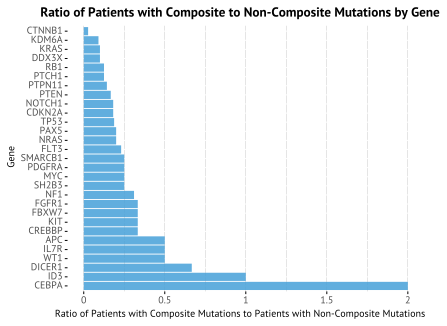

<ggplot: (8768930802710)>

In [254]:
p1

In [222]:
viz = composite_gene_counts[composite_gene_counts['composite_count']>0]
viz = viz[viz.Gene != 'TPMT']
viz.sort_values('composite_count',ascending=False,inplace=True)

In [232]:
gene_list = viz.Gene.to_list()
gene_cat = pd.Categorical(viz['Gene'],categories = gene_list)
viz['cat'] = gene_cat

In [237]:
p2 = ggplot(viz) + aes(x='cat',y='composite_count') + geom_col(fill='#2591d9',alpha=0.7) + coord_flip() + \
labs(y='Number of Patients with Composite Mutations',x='Gene',title='Number of Patients with Composite Mutations by Gene') + \
theme(panel_background = element_rect(fill = 'white'), panel_grid_minor_x = element_line( size=.1, color="black" ),
      panel_grid_major_x = element_line( size=.1, color="black" ),
    plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none')

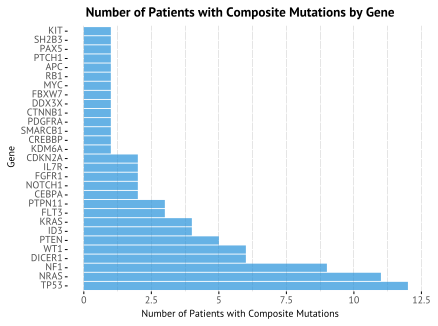

<ggplot: (8768926368455)>

In [238]:
p2

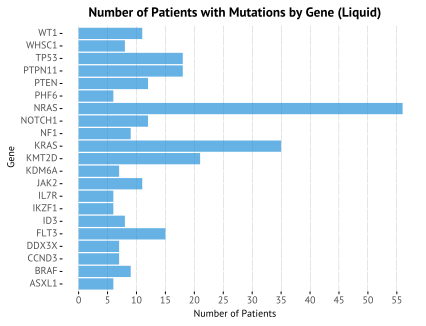

<ggplot: (8742892759718)>

In [132]:
ggplot(viz) + aes(x='Gene',y='counts') + geom_col(fill='#2591d9',alpha=0.7) + coord_flip() + \
ggtitle('Number of Patients with Mutations by Gene (Liquid)') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_x = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     legend_position = 'none') + \
labs(x='Gene',y='Number of Patients') + \
scale_y_continuous(breaks = range(0, 85,5))

In [108]:
viz = composite_gene_counts[composite_gene_counts['Count']>0]

In [109]:
viz = viz[viz.Gene != 'TPMT']

In [110]:
patients_composite = ggplot(viz) + aes(x='Gene',y='Count') + geom_col(fill='#2591d9',alpha=0.7) + \
scale_y_continuous(limits=(0,16),breaks=range(0,18,2),expand=(0,0.5)) +\
ggtitle('Number of Patients with Composite Mutations by Gene') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_y = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     axis_text_x = element_text(angle = 90)) + \
labs(x='Gene',y='Number of Patients')

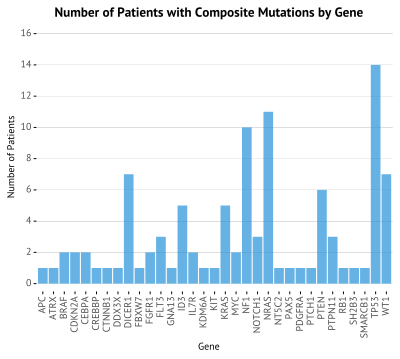

<ggplot: (8742894856066)>

In [111]:
patients_composite

#### Mutations/Composite Mutations by Tumor Tissue Type

In [123]:
composite_gene_counts_liq={}

for gene in list(maf['Gene'].unique()):
    df= maf[maf['Gene']==gene][maf['Composite_Mutation']=='True'][maf['Tumor_Tissue_Type']=='Liquid']
    num_samples = df['short_sample'].nunique()
    
    composite_gene_counts_liq[gene] = []
    composite_gene_counts_liq[gene].append(num_samples)

In [124]:
composite_gene_counts_liq = pd.DataFrame(composite_gene_counts_liq).transpose()
composite_gene_counts_liq.reset_index(inplace=True)
composite_gene_counts_liq.rename(columns={'index':'Gene',0:'Count'},inplace=True)

In [125]:
viz = composite_gene_counts_liq[composite_gene_counts_liq['Count']>0]
viz = viz[viz.Gene != 'TPMT']

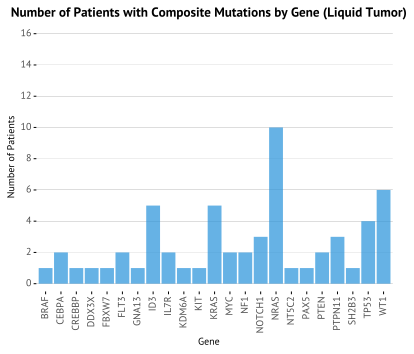

<ggplot: (8742895158248)>

In [126]:
ggplot(viz) + aes(x='Gene',y='Count') + geom_col(fill='#2591d9',alpha=0.7) + \
scale_y_continuous(limits=(0,16),breaks=range(0,18,2),expand=(0,0.5)) +\
ggtitle('Number of Patients with Composite Mutations by Gene (Liquid Tumor)') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_y = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     axis_text_x = element_text(angle = 90)) + \
labs(x='Gene',y='Number of Patients')

In [89]:
composite_gene_counts_sol={}

for gene in list(maf['Gene'].unique()):
    df= maf[maf['Gene']==gene][maf['Composite_Mutation']=='True'][maf['Tumor_Tissue_Type']=='Solid']
    num_samples = df['short_sample'].nunique()
    
    composite_gene_counts_sol[gene] = []
    composite_gene_counts_sol[gene].append(num_samples)

In [90]:
composite_gene_counts_sol = pd.DataFrame(composite_gene_counts_sol).transpose()
composite_gene_counts_sol.reset_index(inplace=True)
composite_gene_counts_sol.rename(columns={'index':'Gene',0:'Count'},inplace=True)

In [91]:
viz = composite_gene_counts_sol[composite_gene_counts_sol['Count']>0]
viz = viz[viz.Gene != 'TPMT']

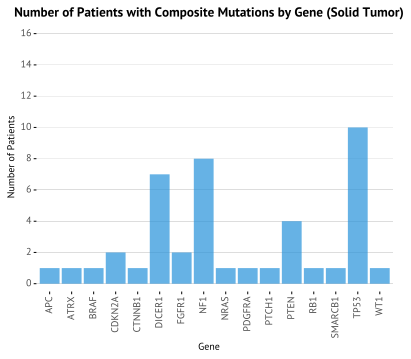

<ggplot: (8742892546473)>

In [92]:
ggplot(viz) + aes(x='Gene',y='Count') + geom_col(fill='#2591d9',alpha=0.7) + \
scale_y_continuous(limits=(0,16),breaks=range(0,18,2),expand=(0,0.5)) +\
ggtitle('Number of Patients with Composite Mutations by Gene (Solid Tumor)') + \
theme(panel_background = element_rect(fill = 'white'),panel_grid_major_y = element_line( size=.1, color="black" ),
     plot_title=element_text(fontproperties=title_text),text=element_text(fontproperties=body_text),
     axis_text_x = element_text(angle = 90)) + \
labs(x='Gene',y='Number of Patients')

In [82]:
maf.Gene.unique()

array(['ALK', 'BRAF', 'NRAS', 'NF1', 'CDKN2A', 'PIK3CA', 'KMT2D', 'CBL',
       'PTCH1', 'DICER1', 'CTNNB1', 'PTPN11', 'WT1', 'H3F3A', 'ATRX',
       'PDGFRA', 'TP53', 'HIST1H3B', 'IDH1', 'CIC', 'CREBBP', 'PTEN',
       'KRAS', 'KDM6A', 'ACVR1', 'IL7R', 'STAT5B', 'FGFR1', 'MYOD1',
       'ABL1', 'SMARCB1', 'NOTCH1', 'IKZF1', 'GATA1', 'FGFR4', 'ASXL1',
       'JAK2', 'NCOR2', 'GNA11', 'PIK3R1', 'FLT3', 'CSF3R', 'DDX3X',
       'SMARCA4', 'FBXW7', 'HRAS', 'NF2', 'EED', 'NT5C2', 'ARID1A',
       'MAP2K1', 'SETBP1', 'CCND3', 'SUZ12', 'SETD2', 'CRLF2', 'MYC',
       'RB1', 'ERBB4', 'APC', 'ID3', 'EZH2', 'PAX5', 'ZMYM3', 'PHF6',
       'PPM1D', 'ASXL2', 'TCF3', 'MTOR', 'STAT3', 'IDH2', 'RET', 'GNA13',
       'WHSC1', 'MET', 'RUNX1', 'GATA3', 'JAK1', 'CHD7', 'EBF1', 'TET2',
       'SH2B3', 'USP7', 'MSH6', 'JAK3', 'NPM1', 'GATA2', 'ARID1B', 'MYCN',
       'CEBPA', 'KIT', 'PRPS1', 'TPMT', 'TSC2', 'CDKN2B-AS1', 'ESR1',
       'EGFR', 'TERT'], dtype=object)

In [198]:
maf.to_csv('maf_w_tissue_date.maf',sep='\t',header=True,index=None)